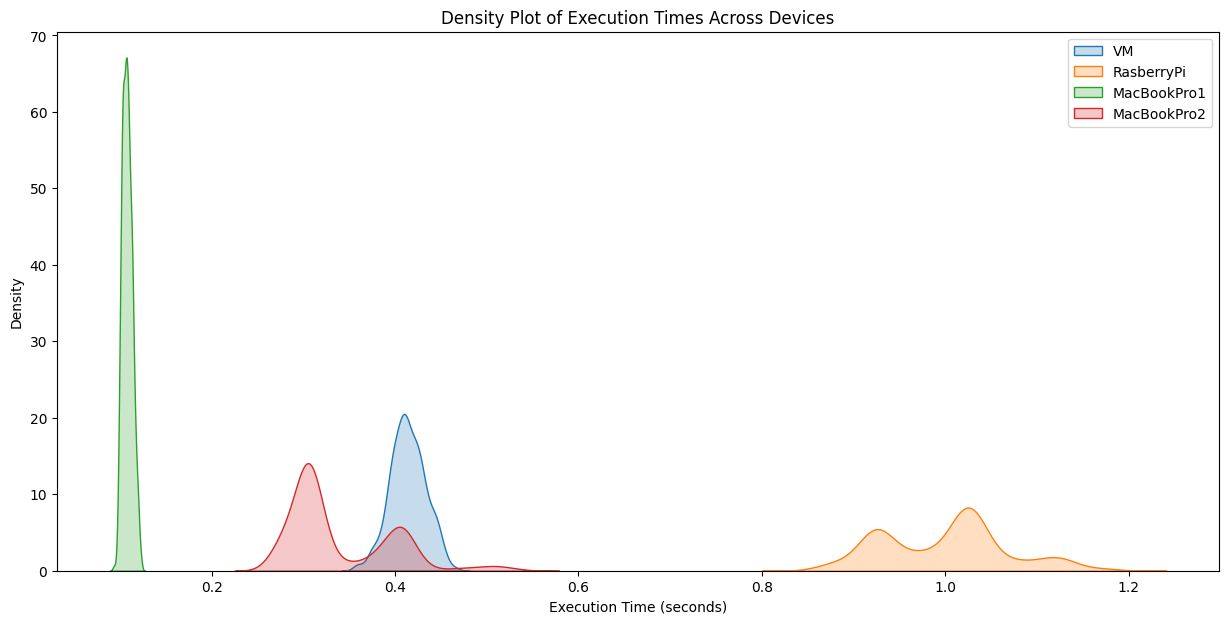

Levene's Test p-value   : 0.00017185030169415284
ANOVA Test p-value      : 0.0

We reject the null hypothesis: There is a significant difference in execution times across devices.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Get the directory where the script is located
script_dir = os.path.dirname('.')  # This gets the directory where the script is located

# Define a function to clean and filter each dataset
def clean_and_filter_dataset(file_name):
    file_path = os.path.join(script_dir, file_name)  # Construct the full file path
    df = pd.read_csv(file_path)
    
    # Optionally drop the 'Time' column if it's not needed for further analysis
    if 'Time' in df.columns:
        df.drop('Time', axis=1, inplace=True)
    
    # Calculate Q1, Q3, and IQR for 'Execution Time'
    Q1 = df['Execution Time'].quantile(0.25)
    Q3 = df['Execution Time'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_df = df[(df['Execution Time'] >= lower_bound) & (df['Execution Time'] <= upper_bound)]
    
    # Save the filtered DataFrame to a new CSV file
    filtered_file_path = os.path.join(script_dir, file_name.split('.')[0] + '_filtered.csv')
    filtered_df.to_csv(filtered_file_path, index=False)
    
    return filtered_df

# Names of the dataset files
file_names = ['VM.csv', 'RasberryPi.csv', 'MacBookPro1.csv', 'MacBookPro2.csv']
device_names = ['VM', 'RaspberryPi', 'MacBookPro1', 'MacBookPro2']

# Loop through each file name, clean, filter, and plot
plt.figure(figsize=(15, 7))
for file_name in file_names:
    df = clean_and_filter_dataset(file_name)
    sns.kdeplot(df['Execution Time'], fill=True, label=file_name.split('.')[0])

plt.title('Density Plot of Execution Times Across Devices')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()


# Load and combine datasets
combined_data = pd.DataFrame()
for file_name, device_name in zip(file_names, device_names):
    temp_df = pd.read_csv(os.path.join(script_dir, file_name))
    temp_df['Device'] = device_name
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Significance level
alpha = 0.05

# Homogeneity of variances (Levene's Test)
stat, p_val_levene = stats.levene(combined_data['Execution Time'][combined_data['Device'] == 'VM'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'RaspberryPi'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro1'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro2'])

print(f"Levene's Test p-value   : {p_val_levene}")


# ANOVA Test
anova_result = stats.f_oneway(combined_data['Execution Time'][combined_data['Device'] == 'VM'],
                              combined_data['Execution Time'][combined_data['Device'] == 'RaspberryPi'],
                              combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro1'],
                              combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro2'])

print(f"ANOVA Test p-value      : {anova_result.pvalue}")
print()

# Interpret results with an if statement
if anova_result.pvalue < alpha:
    print("We reject the null hypothesis: There is a significant difference in execution times across devices.")
else:
    print("We fail to reject the null hypothesis: There is no significant difference in execution times across devices.")

